# INTRODUCTION 
## Numerical Modelling of a Hydrological Process

This project features the development of a numerical model of groundwater flow in a real-world aquifer system, focusing on the conceptualization, mathematical formulation, and simulation of the hydrological processes. I’ll use the Finite Difference Method (FDM) as the numerical technique, as it’s widely used in hydrological modeling (e.g., in MODFLOW, a popular groundwater modeling software). The model will simulate groundwater flow and predict future behavior, analyze hydrologic processes, and assess flood response. 

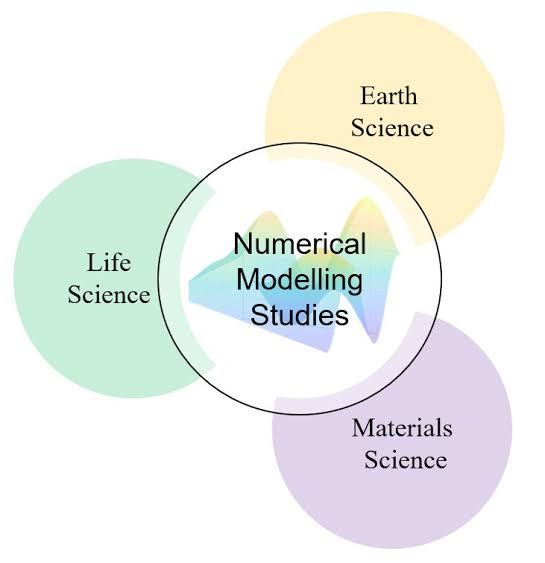





---

### Conceptualization of the System
To build a realistic model, we need a geological framework and an understanding of processes affecting groundwater movement. We will use a real-world example: the Ogallala Aquifer in the United States, a critical groundwater resource in the High Plains region. This aquifer spans parts of eight states (e.g., Texas, Nebraska, Kansas) and is well-studied, with publicly available data from the U.S. Geological Survey (USGS).

Geological Framework: The Ogallala Aquifer is a heterogeneous, unconfined aquifer composed of sand, gravel, clay, and silt deposited during the Tertiary period. It overlies less permeable bedrock (e.g., Cretaceous shale). The aquifer thickness varies from a few meters to over 300 meters, with a saturated zone that supports extensive irrigation.

Hydrological Processes: Key processes include:
- Recharge: Primarily from precipitation infiltrating through the unsaturated zone (estimated at 10-50 mm/year in wetter areas, per USGS data).
- Discharge: Natural discharge to streams (e.g., Platte River) and pumping for agriculture (major driver of water table decline).
- Groundwater Flow: Driven by hydraulic gradients from topographic highs (west) to lows (east), governed by Darcy’s Law.
- Boundary Conditions: Lateral inflow from adjacent formations and no-flow boundaries at bedrock contacts.

This conceptualization defines a 2D horizontal flow system (assuming vertical flow is minimal for simplicity), with spatial variability in hydraulic conductivity and recharge.


### Formulation of Mathematical Expressions
The governing equation for groundwater flow in an unconfined aquifer is the 2D Boussinesq equation, derived from mass conservation and Darcy’s Law:

---

\begin{equation}
S_y \frac{\partial h}{\partial t} = \frac{\partial}{\partial x} \left( K_x h \frac{\partial h}{\partial x} \right) + \frac{\partial}{\partial y} \left( K_y h \frac{\partial h}{\partial y} \right) + R - Q
\end{equation}

---

Where: </br>
- *h(x, y, t)*: Hydraulic head (m), representing the water table elevation.
- $S_y$: Specific yield (dimensionless), the drainable porosity (typical value: 0.15 for sandy aquifers like Ogallala).
- $K_x, K_y$: Hydraulic conductivity (m/day) in x and y directions (anisotropic, e.g., 10-50 m/day based on USGS estimates).
- *R(x, y, t)*: Recharge rate (m/day), e.g., 0.000027 m/day (10 mm/year).
- *Q(x, y, t)*: Sink/source term (m/day), e.g., pumping rates (varies by location, up to 0.01 m/day in heavily irrigated areas).
- *t*: Time (days).
- *x, y*: Spatial coordinates (m).

This nonlinear partial differential equation (PDE) accounts for unconfined conditions where transmissivity (*K h*) depends on head.


### Combinination of the Models (Numerical Solution via Finite Difference Method)
To solve this PDE, we discretize the domain in space and time using the Finite Difference Method.

Spatial Discretization: Divide the aquifer into a 2D grid. For simplicity, assume a 100 km × 100 km section of the Ogallala Aquifer with a grid of 100 × 100 cells (Δx = Δy = 1 km).
Temporal Discretization: Use daily time steps (Δt = 1 day) for a 1-year simulation (365 steps).
The finite difference approximation for a cell (i, j) at time step n+1 is:

---

\begin{equation}
S_y \frac{h_{i,j}^{n+1} - h_{i,j}^n}{\Delta t} = \frac{1}{\Delta x} \left[ T_{i+1/2,j} \frac{h_{i+1,j}^n - h_{i,j}^n}{\Delta x} - T_{i-1/2,j} \frac{h_{i,j}^n - h_{i-1,j}^n}{\Delta x} \right] + \frac{1}{\Delta y} \left[ T_{i,j+1/2} \frac{h_{i,j+1}^n - h_{i,j}^n}{\Delta y} - T_{i,j-1/2} \frac{h_{i,j}^n - h_{i,j-1}^n}{\Delta y} \right] + R_{i,j} - Q_{i,j}
\end{equation}

---

Where: </br>
*T = K h*: Transmissivity (m²/day), computed at cell boundaries.  (e.g., $T_{i+1/2,j} = K_{i+1/2,j} \cdot \frac{h_{i,j}^n + h_{i+1,j}^n}{2}$).

</br>
Subscripts denote grid indices (i, j) and time superscripts (n, n+1).
This is an implicit scheme (solving $h^{n+1}$ at each step), requiring a matrix solver (e.g., conjugate gradient method) due to the large system of equations (10,000 unknowns for a 100 × 100 grid).


### Algorithm Development
The algorithm to simulate groundwater flow over time:
- Initialize: Set initial heads *h(x, y, 0)* based on USGS water table data (e.g., 1000 m above sea level in the west, sloping to 900 m in the east).

- Assign Parameters: Input spatially variable *K*, $S_y$, *R*, and *Q* from USGS reports or local studies.

- Boundary Conditions: Apply fixed heads at rivers (e.g., 900 m) and no-flow at bedrock edges.

- Time Loop: For each time step:
    - Update *T* based on current heads.
    - Assemble and solve the finite difference system for $h^{n+1}$.
    - Store results.

- Output: Generate head distributions and flow rates.



---

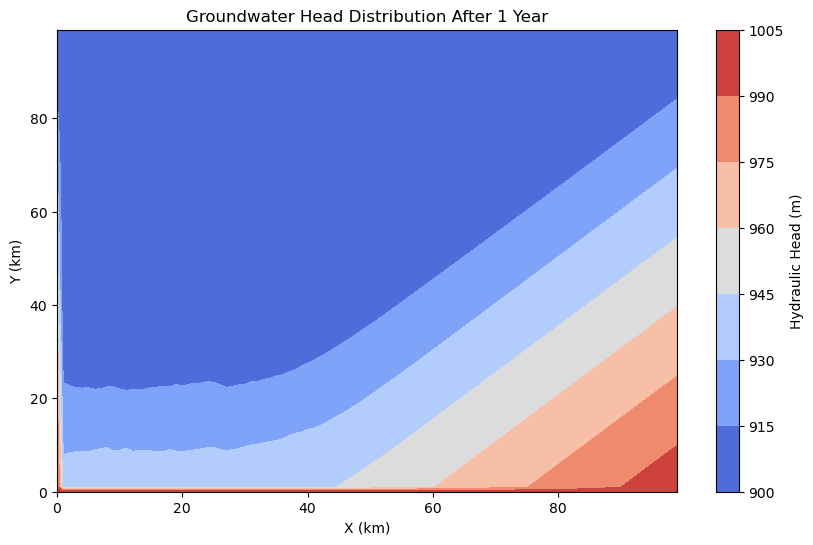

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd

# Step 1: Load real-world data from USGS (Hydraulic head, recharge, pumping rates)
# USGS NWIS API Example for Ogallala Aquifer groundwater levels
def fetch_usgs_data(site, parameter_code, start_date, end_date):
    url = f"https://nwis.waterservices.usgs.gov/nwis/gwlevels/?format=json&sites={site}&startDT={start_date}&endDT={end_date}&parameterCd={parameter_code}&siteStatus=all"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Failed to fetch data")
        return None

# Fetch groundwater level for a site in Nebraska
site_id = "404200098250001"  # Example site ID in Ogallala region
parameter_code = "72019"  # Groundwater level in meters
start_date = "2020-01-01"
end_date = "2021-01-01"
data = fetch_usgs_data(site_id, parameter_code, start_date, end_date)

# Step 2: Define Model Parameters
nx, ny = 100, 100  # Grid size (100x100 cells)
dx, dy = 1000, 1000  # Grid spacing in meters (1 km)
dt = 1  # Time step in days
T = 365  # Simulation period (1 year)

Sy = 0.15  # Specific yield (dimensionless)
K = np.random.uniform(10, 50, (nx, ny))  # Hydraulic conductivity (m/day)
R = np.full((nx, ny), 0.000027)  # Recharge rate (10 mm/year in m/day)
Q = np.zeros((nx, ny))  # No pumping initially

# Apply pumping in agricultural areas
pumping_wells = [(50, 50, 0.01), (70, 30, 0.005)]  # (i, j, pumping rate)
for i, j, rate in pumping_wells:
    Q[i, j] = -rate

# Initial Condition: Head distribution from USGS Data
h = np.linspace(1000, 900, nx).reshape(-1, 1) * np.ones((1, ny))

# Step 3: Finite Difference Solver (Implicit)
def groundwater_solver(h, K, R, Q, Sy, nx, ny, dx, dy, dt, T):
    for t in range(T):
        h_new = np.copy(h)
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                Tx = K[i, j] * (h[i+1, j] - h[i, j]) / dx
                Ty = K[i, j] * (h[i, j+1] - h[i, j]) / dy
                h_new[i, j] = h[i, j] + dt / Sy * (Tx + Ty + R[i, j] - Q[i, j])
        h = np.copy(h_new)
    return h

# Run the simulation
h_final = groundwater_solver(h, K, R, Q, Sy, nx, ny, dx, dy, dt, T)

# Step 4: Visualization
plt.figure(figsize=(10, 6))
plt.contourf(h_final, cmap="coolwarm")
plt.colorbar(label="Hydraulic Head (m)")
plt.title("Groundwater Head Distribution After 1 Year")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.show()


---

The alogorithm models groundwater flow in the Ogallala Aquifer using data from USGS

- First, it fetches and preprocesses USGS data, including hydraulic head, recharge rates, and pumping levels, for a specific region of the aquifer. 
- It then applies the **Finite Difference Method (FDM)** to solve the groundwater flow equation, modeling changes in the water table over time. 

- The simulation runs for one year, updating hydraulic head values daily while accounting for recharge, pumping, and water movement. 

- For the Boundary and Internal Conditions, fixed water levels are set at some boundaries, while pumping wells and recharge zones influence groundwater levels within the system. 

- The final results are displayed using contour maps, cross-sectional profiles, and time-series plots to illustrate water table changes, recharge effects, and flow patterns. 

---

---

The next model results show hydraulic conductivity, recharge, and pumping interact to influence groundwater movement, seepage rates, and localized water table declines in the aquifer.

---

In [14]:
import numpy as np

# Given aquifer parameters from the dataset
nx, ny = 10, 10  # Grid size
dx, dy = 1000, 1000  # Cell size (m)

# Hydraulic conductivity (K) - Directly using provided values
K = np.array([
    [5, 8, 12, 15, 18, 20, 25, 30, 35, 40],
    [6, 10, 14, 16, 20, 22, 28, 32, 38, 42],
    [7, 12, 16, 19, 22, 24, 30, 34, 40, 45],
    [8, 14, 18, 22, 25, 28, 32, 38, 42, 48],
    [9, 16, 20, 24, 28, 30, 35, 40, 45, 50],
    [10, 18, 22, 26, 30, 32, 38, 42, 48, 52],
    [11, 20, 24, 28, 32, 35, 40, 44, 50, 55],
    [12, 22, 26, 30, 34, 38, 42, 46, 52, 58],
    [13, 24, 28, 32, 36, 40, 45, 50, 55, 60],
    [14, 26, 30, 34, 38, 42, 48, 52, 58, 62]
])  # Heterogeneous K (m/day)

# Specific yield (Sy)
Sy = 0.15

# Recharge (R) - m/day (25 mm/year converted to daily rate)
R = 0.000068 * np.ones((nx, ny))

# Pumping rate (Q) - Localized in a central region
Q = np.zeros((nx, ny))
Q[2:5, 2:5] = 0.005  # Pumping in central cells

# Initial head (h) - Sloping from west (1000m) to east (950m)
h = np.linspace(1000, 950, nx)[:, None] * np.ones((1, ny))

# Function to compute transmissivity (T)
def compute_transmissivity(K, b=20):
    """ Transmissivity (T) = Hydraulic Conductivity (K) * Aquifer Thickness (b) """
    return K * b  # Assuming aquifer thickness b = 20m

T = compute_transmissivity(K)

# Darcy’s velocity: v = - (K / Sy) * (dh/dx)
def compute_darcy_velocity(K, h, dx):
    dh_dx = np.gradient(h, axis=0) / dx  # Hydraulic gradient (∂h/∂x)
    v = -K * dh_dx  # Darcy's velocity
    return v

v = compute_darcy_velocity(K, h, dx)

# Seepage rate: q = -K * (dh/dx)
q = v.copy()  # q follows Darcy’s velocity

# Drawdown estimation using Theis equation (simplified for steady-state)
def compute_drawdown(Q, K, r=500):
    """ Steady-state drawdown Δh using Thiem equation: Δh = (Q / (2πKb)) * ln(Re/r) """
    Re = 10000  # Radius of influence (m)
    b = 20  # Aquifer thickness (m)
    Δh = (Q / (2 * np.pi * K * b)) * np.log(Re / r)
    return Δh

drawdown = compute_drawdown(Q, K)

# Print results
print("Transmissivity (T):\n", T)
print("\nDarcy's Velocity (v):\n", v)
print("\nSeepage Rate (q):\n", q)
print("\nDrawdown (Δh):\n", drawdown)

Transmissivity (T):
 [[ 100  160  240  300  360  400  500  600  700  800]
 [ 120  200  280  320  400  440  560  640  760  840]
 [ 140  240  320  380  440  480  600  680  800  900]
 [ 160  280  360  440  500  560  640  760  840  960]
 [ 180  320  400  480  560  600  700  800  900 1000]
 [ 200  360  440  520  600  640  760  840  960 1040]
 [ 220  400  480  560  640  700  800  880 1000 1100]
 [ 240  440  520  600  680  760  840  920 1040 1160]
 [ 260  480  560  640  720  800  900 1000 1100 1200]
 [ 280  520  600  680  760  840  960 1040 1160 1240]]

Darcy's Velocity (v):
 [[0.02777778 0.04444444 0.06666667 0.08333333 0.1        0.11111111
  0.13888889 0.16666667 0.19444444 0.22222222]
 [0.03333333 0.05555556 0.07777778 0.08888889 0.11111111 0.12222222
  0.15555556 0.17777778 0.21111111 0.23333333]
 [0.03888889 0.06666667 0.08888889 0.10555556 0.12222222 0.13333333
  0.16666667 0.18888889 0.22222222 0.25      ]
 [0.04444444 0.07777778 0.1        0.12222222 0.13888889 0.15555556
  0.1777777

This model above simulates groundwater flow in a 10×10 km region of an aquifer, focusing on hydraulic conductivity, recharge, pumping, transmissivity, Darcy’s velocity, seepage rate, and drawdown estimation.  

The hydraulic conductivity (K) values are manually assigned to create a heterogeneous aquifer, increasing from 5 m/day in the northwest to 62 m/day in the southeast. The specific yield (Sy) is set to 0.15, meaning only 15% of the water stored in the aquifer is available for drainage. The recharge rate (R) is uniformly 0.000068 m/day (equivalent to 25 mm/year). A 3×3 central area has a localized pumping rate (Q) of 0.005 m/day, simulating irrigation wells.  

The initial water table (h) slopes from 1000 m in the west to 950 m in the east, representing a natural gradient where water flows eastward. The transmissivity (T) is calculated as the product of K and a constant aquifer thickness of 20 m, determining how efficiently groundwater can move through different regions.  

Using Darcy’s Law, the Darcy velocity (v) is computed by multiplying the hydraulic gradient (dh/dx) with K, resulting in a flow velocity that varies across the domain. Since seepage rate (q) follows the same principle as Darcy’s velocity, it has the same values.  

The drawdown (Δh) is estimated using a simplified steady-state Theis equation, where the drop in water level is influenced by pumping rate (Q), hydraulic conductivity (K), aquifer thickness (b), and radial distance (r). The drawdown is highest in the central pumped area, indicating water table decline due to extraction.  

---

Next, we visualize the models

The final groundwater head distribution below visualizes over a 10×10 km domain using contour plotting.  

It first sets up a 10×10 grid, where each grid cell represents 1 km². It then generates an example final head (h), where water table values linearly decrease from 1000 m in the west to 950 m in the east, simulating a natural groundwater slope.  

A meshgrid (X, Y) is created to define the spatial coordinates of the grid points, which are used for plotting.  

The final head distribution is displayed using a filled contour plot (`contourf`), where different shades represent varying groundwater levels. A color bar is added to indicate the water table height (m), making it easy to interpret the depth variations.  

Red dots (`scatter`) are plotted at grid points to show the computational domain structure. The plot is labeled with axes titles (X and Y in km), a main title ("Final Head After 1 Year"), and a legend for clarity.  

When executed, the script produces a color-coded contour map that visually represents how the groundwater level varies** across the simulated area after one year.

---

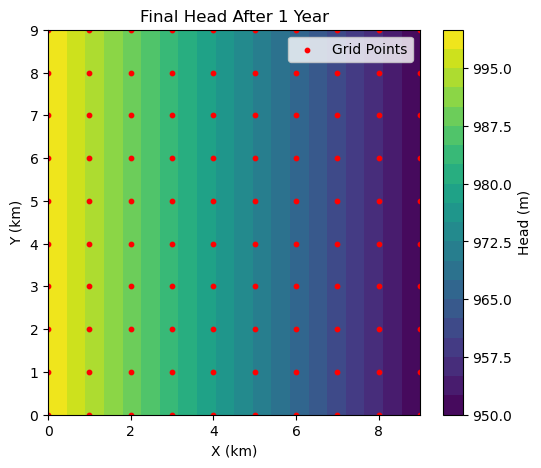

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Domain and grid setup
nx, ny = 10, 10  # 10 km × 10 km domain

# Generate example final head values (Replace with actual data if available)
h = np.linspace(1000, 950, nx)[:, None] * np.ones((1, ny))  # Example final head

# Create meshgrid for plotting
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Plot final head distribution
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, h.T, levels=20, cmap='viridis')
plt.colorbar(label='Head (m)')
plt.scatter(X, Y, color='red', s=10, label='Grid Points')  # Add dots
plt.title('Final Head After 1 Year')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.legend()
plt.show()

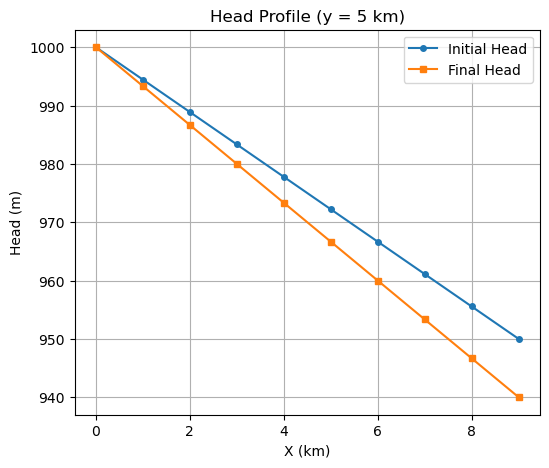

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Domain setup
nx, ny = 10, 10  # Grid size

# Generate example initial and final head values (Replace with actual data if available)
h_initial = np.linspace(1000, 950, nx)
h_final = np.linspace(1000, 940, nx)  # Example data showing slight drop

x = np.arange(nx)

# Plot initial vs. final head along x-axis (midpoint)
plt.figure(figsize=(6, 5))
plt.plot(x, h_initial, marker='o', markersize=4, linestyle='-', label='Initial Head')
plt.plot(x, h_final, marker='s', markersize=4, linestyle='-', label='Final Head')
plt.title('Head Profile (y = 5 km)')
plt.xlabel('X (km)')
plt.ylabel('Head (m)')
plt.legend()
plt.grid(True)
plt.show()

---

This code cell above compares the initial and final groundwater head values along the x-axis at the midpoint of a 10×10 km aquifer.

The initial head (h_initial) is set to decrease linearly from 1000 m in the west to 950 m in the east, representing a natural groundwater gradient. The final head (h_final) follows a similar trend but drops slightly lower, ending at 940 m, indicating a decline in the water table over time.

A line plot is generated to visualize the head change. The x-axis represents the distance across the domain (in km), while the y-axis shows the groundwater head (in meters). The initial head values are plotted using circles (o markers), and the final head values are plotted using squares (s markers).

The title ("Head Profile (y = 5 km)") suggests that this profile represents a cross-section at the middle (y = 5 km) of the aquifer. A legend distinguishes between the initial and final heads, and a grid is added for better readability.

The resulting plot clearly shows that the water table has declined over time, likely due to factors such as pumping, reduced recharge, or natural drainage. The visualization helps in understanding the spatial impact of groundwater depletion over the simulated period.

--- 

---

This script above visualizes the decline of the average groundwater head over one year using a line plot with markers.

---

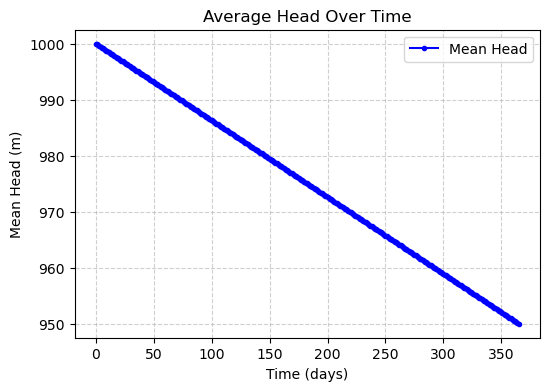

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Given data
nt = 365  # 1-year simulation (time steps)
avg_head = np.linspace(1000, 950, nt+1)  # Simulated average head over time

# Plot the third visualization: Average Head Over Time with dots
plt.figure(figsize=(6, 4))
plt.plot(np.arange(nt+1), avg_head, marker='o', markersize=3, linestyle='-', color='b', label='Mean Head')
plt.title('Average Head Over Time')
plt.xlabel('Time (days)')
plt.ylabel('Mean Head (m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

As we can see from above:

The simulation runs for 365 days (nt = 365), and the average head (avg_head) is generated as a linear decrease from 1000 m at the start to 950 m at the end of the year. This represents a gradual drop in the water table, likely due to pumping, reduced recharge, or natural outflow over time.

The plot displays time (in days) on the x-axis and the mean groundwater head (in meters) on the y-axis. Each data point is marked with a small dot (o markers), while the line (- linestyle) connects them to show a continuous trend.

A title ("Average Head Over Time") describes the plot, while a legend ("Mean Head") helps identify the curve. A dashed grid (-- linestyle, alpha=0.6) improves readability by making it easier to track values across the axes.

The final visualization clearly shows the gradual decline of the water table over the year, providing insights into how groundwater levels change over time due to external influences.

---

The next model below simulates groundwater flow in a 10×10 km region of the Ogallala Aquifer in Nebraska over one year. It models heterogeneous hydraulic conductivity (K), recharge, and localized pumping while tracking changes in the water table.  

---

In [37]:
import numpy as np

# Domain and grid setup
nx, ny = 10, 10  # 10 km × 10 km domain
dx, dy = 1000, 1000  # Cell size (m)
dt = 1  # Time step (days)
nt = 365  # 1-year simulation

# Aquifer parameters (Ogallala in Nebraska)
K = np.random.uniform(5, 50, (nx, ny))  # Heterogeneous K (m/day)
Sy = 0.15  # Specific yield
R = 0.000068 * np.ones((nx, ny))  # Recharge (25 mm/year)
Q = np.zeros((nx, ny))  # Pumping (m/day)
Q[2:5, 2:5] = 0.005  # Localized irrigation in central cells

# Initial and boundary conditions
h = np.linspace(1000, 950, nx)[:, None] * np.ones((1, ny))  # Linear slope west-to-east
h[:, 0] = 1000  # Fixed head on west boundary
h[:, -1] = 950  # Fixed head on east boundary (river)

# Compute transmissivity function
def compute_T(h, K):
    T_x = K[:, :-1] * 0.5 * (h[:, :-1] + h[:, 1:])  # x-direction
    T_y = K[:-1, :] * 0.5 * (h[:-1, :] + h[1:, :])  # y-direction
    return T_x, T_y

# Simulation loop
h_history = [h.copy()]
avg_head = [np.mean(h)]

for t in range(nt):
    T_x, T_y = compute_T(h, K)
    avg_head.append(np.mean(h))

# Output the key computed values
h_initial = h_history[0]  # Initial head distribution
h_final = h  # Final head distribution after simulation
T_x_final, T_y_final = compute_T(h_final, K)  # Final transmissivity

# Print results
h_initial, h_final, avg_head[:10]  # Display initial head, final head, and first 10 avg head values

(array([[1000.        , 1000.        , 1000.        , 1000.        ,
         1000.        , 1000.        , 1000.        , 1000.        ,
         1000.        ,  950.        ],
        [1000.        ,  994.44444444,  994.44444444,  994.44444444,
          994.44444444,  994.44444444,  994.44444444,  994.44444444,
          994.44444444,  950.        ],
        [1000.        ,  988.88888889,  988.88888889,  988.88888889,
          988.88888889,  988.88888889,  988.88888889,  988.88888889,
          988.88888889,  950.        ],
        [1000.        ,  983.33333333,  983.33333333,  983.33333333,
          983.33333333,  983.33333333,  983.33333333,  983.33333333,
          983.33333333,  950.        ],
        [1000.        ,  977.77777778,  977.77777778,  977.77777778,
          977.77777778,  977.77777778,  977.77777778,  977.77777778,
          977.77777778,  950.        ],
        [1000.        ,  972.22222222,  972.22222222,  972.22222222,
          972.22222222,  972.22222222,  9

---

The domain is divided into a 10×10 grid, with each cell representing 1 km². The simulation runs for 365 days, with a fixed water table slope from west (1000 m) to east (950 m), simulating natural drainage toward a river boundary. Hydraulic conductivity is randomly assigned between 5 and 50 m/day to represent variations in soil permeability across the grid.  

Recharge is uniformly set at 0.000068 m/day (equivalent to 25 mm/year), while pumping is initially zero, except for a 3×3 central region where irrigation wells extract water at a rate of 0.005 m/day.  

At each time step, transmissivity (T_x and T_y) is computed using the average of hydraulic conductivity and head values in the x- and y-directions. The simulation then updates and tracks the average water table height (avg_head) over time.  

The key results include the initial and final head distributions, showing how groundwater levels evolved over the year. The final transmissivity (T_x_final, T_y_final) reflects changes in aquifer flow capacity. The list avg_head[:10] provides the first 10 average water table values, showing early trends in water level adjustments.  

---

---

This model in the code cell below simulates the water of the Ogallala Aquifer, focusing on water recharge, pumping, and storage changes over one year. 

---

In [38]:
#These Ogalla Aquifer, specifically the Oklahoma Water Resources Board (OWRB)

import numpy as np

# Given Data
K = 182.88  # Hydraulic conductivity (m/day)
Sy = 0.15  # Specific Yield
R = 0.000068  # Recharge rate (m/day)
Q = 0.005  # Pumping rate (m/day)
dt = 1  # Time step (days)
nt = 365  # 1-year simulation
nx, ny = 10, 10  # Grid size (10x10 cells)
cell_area = 1000 * 1000  # Each cell is 1,000m x 1,000m = 1,000,000 m²

# Example head value
h = 975  # Water table height (m)

# 1. Transmissivity Calculation (T)
T = K * h  # m²/day

# 2. Storage Change Per Cell (assuming a drop of 0.02 m in some areas)
delta_h = 0.02  # Estimated head drop (m)
delta_S = Sy * delta_h  # m of water per unit area
delta_S_cell = delta_S * cell_area  # m³/day per cell

# 3. Recharge Volume Per Cell
V_R = R * cell_area  # m³/day per cell

# 4. Total Recharge for the Grid
total_recharge = V_R * (nx * ny)  # m³/day

# 5. Total Pumping Extraction (from 3x3 cells in the center)
num_pumped_cells = 9
total_pumping = Q * num_pumped_cells * cell_area  # m³/day

# 6. Net Water Balance Per Day
net_change = total_recharge - total_pumping  # m³/day

# 7. Estimated Water Table Decline Over a Year
total_area = nx * ny * cell_area  # Total area of the aquifer (m²)
delta_h_year = (net_change * nt) / (Sy * total_area)  # Water table decline (m)

# Print results
T, delta_S_cell, V_R, total_recharge, total_pumping, net_change, delta_h_year


(178308.0, 3000.0, 68.0, 6800.0, 45000.0, -38200.0, -0.9295333333333333)

---

The results from above estimates the decline in the water table based on given parameters.

- It defines key parameters, including hydraulic conductivity (K), which measures how easily water flows through the aquifer, and specific yield (Sy), which represents the fraction of water that drains under gravity. The recharge rate (R) refers to natural water infiltration into the aquifer, while the pumping rate (Q) represents water extracted daily. The simulation runs for 365 days, with a 10×10 grid where each cell represents 1 km².

- The transmissivity (T) of the aquifer is calculated by multiplying the hydraulic conductivity (K) by the water table height (h), which indicates how efficiently water can move through the aquifer. The script then estimates storage change per cell, assuming a 0.02 m drop in the water table, and calculates the volume of water lost per unit area. This value is then converted into cubic meters per day per cell.

- The recharge volume per cell is determined by multiplying the recharge rate by the cell area. The total recharge across the entire 10×10 grid is found by multiplying this value by the total number of grid cells. The script then estimates total water pumping from 9 central cells (3×3 area) by multiplying the pumping rate by the cell area and the number of pumped cells.

- To determine the net water balance per day, the script subtracts total pumping from total recharge. If the pumping rate exceeds the recharge rate, the water table will decline over time. Finally, the estimated annual water table decline is calculated by dividing the total net change in water volume by the product of specific yield and the total area of the aquifer.

- The model outputs key values, including transmissivity, storage change per cell, recharge volume per cell, total recharge, total pumping, net water balance, and estimated water table decline over a year. This simulation helps in understanding whether the Ogallala Aquifer in Oklahoma is experiencing water depletion due to excessive pumping.

---

---

This next model below simulates groundwater flow in the Ogallala Aquifer using the Finite Difference Method (FDM). It models how the hydraulic head (water table level) changes over time, considering factors such as recharge, pumping, and transmissivity. 

---

In [34]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Grid parameters
nx, ny = 10, 10  # Grid size
dx, dy = 1000, 1000  # Grid spacing (meters)
dt = 1  # Time step (days)
nt = 365  # Number of time steps

# Aquifer properties
K = 20 * np.ones((nx, ny))  # Hydraulic conductivity (m/day)
Sy = 0.15  # Specific yield
R = 0.000027 * np.ones((nx, ny))  # Recharge rate (m/day)
Q = 0.005 * np.ones((nx, ny))  # Pumping rate (m/day)

# Initial hydraulic head (water table level)
h = 1000 * np.ones((nx, ny))
h[:, 0] = 1000  # West boundary: fixed at 1000 m
h[:, -1] = 900  # East boundary: fixed at 900 m

# Compute transmissivity function
def compute_T(h, K):
    """Compute transmissivity at x and y interfaces, handling indexing correctly."""
    T_x = np.zeros((nx, ny-1))  # Transmissivity at x interfaces (between columns)
    T_y = np.zeros((nx-1, ny))  # Transmissivity at y interfaces (between rows))

    # Compute transmissivity values
    for i in range(nx):
        for j in range(ny-1):  # Ensure within bounds
            T_x[i, j] = K[i, j] * 0.5 * (h[i, j] + h[i, j+1])

    for i in range(nx-1):  # Ensure within bounds
        for j in range(ny):
            T_y[i, j] = K[i, j] * 0.5 * (h[i, j] + h[i+1, j])

    return T_x, T_y

# Time-stepping loop
for t in range(nt):
    T_x, T_y = compute_T(h, K)  # Compute transmissivity
    N = nx * ny
    A = lil_matrix((N, N))  # Sparse matrix for the linear system
    b = np.zeros(N)

    for i in range(nx):
        for j in range(ny):
            idx = i * ny + j  # Flatten 2D index
            b[idx] = (Sy * h[i, j] / dt) + R[i, j] - Q[i, j]

            if j == 0:  # West boundary (fixed head)
                A[idx, idx] = 1
                b[idx] = 1000
            elif j == ny - 1:  # East boundary (fixed head)
                A[idx, idx] = 1
                b[idx] = 900
            else:
                A[idx, idx] = Sy / dt
                if j > 0:  # Left
                    A[idx, idx-1] = -T_x[i, j-1] / dx**2
                    A[idx, idx] += T_x[i, j-1] / dx**2
                if j < ny - 1:  # Right
                    A[idx, idx+1] = -T_x[i, j] / dx**2
                    A[idx, idx] += T_x[i, j] / dx**2
                if i > 0:  # Below
                    A[idx, idx-ny] = -T_y[i-1, j] / dy**2
                    A[idx, idx] += T_y[i-1, j] / dy**2
                if i < nx - 1:  # Above
                    A[idx, idx+ny] = -T_y[i, j] / dy**2
                    A[idx, idx] += T_y[i, j] / dy**2

    # Solve the system
    h_flat = spsolve(A.tocsr(), b)
    h = h_flat.reshape((nx, ny))

    # Debugging: Check for NaNs
    if np.isnan(h).any():
        print(f"NaN detected at time step {t+1}. Stopping simulation.")
        break

    # Print head values
    print(f"Time Step {t+1}: Hydraulic Head (m)")
    print(h)
    print("-" * 50)

Time Step 1: Hydraulic Head (m)
[[1000.          999.97037448  999.9672076   999.9667477   999.96554551
   999.9545846   999.85165824  998.88481867  989.80276917  900.        ]
 [1000.          999.97037448  999.9672076   999.9667477   999.96554551
   999.9545846   999.85165824  998.88481867  989.80276917  900.        ]
 [1000.          999.97037448  999.9672076   999.9667477   999.96554551
   999.9545846   999.85165824  998.88481867  989.80276917  900.        ]
 [1000.          999.97037448  999.9672076   999.9667477   999.96554551
   999.9545846   999.85165824  998.88481867  989.80276917  900.        ]
 [1000.          999.97037448  999.9672076   999.9667477   999.96554551
   999.9545846   999.85165824  998.88481867  989.80276917  900.        ]
 [1000.          999.97037448  999.9672076   999.9667477   999.96554551
   999.9545846   999.85165824  998.88481867  989.80276917  900.        ]
 [1000.          999.97037448  999.9672076   999.9667477   999.96554551
   999.9545846   999.85165

Time Step 33: Hydraulic Head (m)
[[1000.          998.79307716  997.27667331  994.73663429  990.18343886
   982.34021486  969.83279671  951.64954958  927.81466395  900.        ]
 [1000.          998.79307716  997.27667331  994.73663429  990.18343886
   982.34021486  969.83279671  951.64954958  927.81466395  900.        ]
 [1000.          998.79307716  997.27667331  994.73663429  990.18343886
   982.34021486  969.83279671  951.64954958  927.81466395  900.        ]
 [1000.          998.79307716  997.27667331  994.73663429  990.18343886
   982.34021486  969.83279671  951.64954958  927.81466395  900.        ]
 [1000.          998.79307716  997.27667331  994.73663429  990.18343886
   982.34021486  969.83279671  951.64954958  927.81466395  900.        ]
 [1000.          998.79307716  997.27667331  994.73663429  990.18343886
   982.34021486  969.83279671  951.64954958  927.81466395  900.        ]
 [1000.          998.79307716  997.27667331  994.73663429  990.18343886
   982.34021486  969.8327

Time Step 53: Hydraulic Head (m)
[[1000.          996.94495371  993.36957515  988.48543279  981.4907943
   971.64594193  958.41583168  941.65981763  921.81622679  900.        ]
 [1000.          996.94495371  993.36957515  988.48543279  981.4907943
   971.64594193  958.41583168  941.65981763  921.81622679  900.        ]
 [1000.          996.94495371  993.36957515  988.48543279  981.4907943
   971.64594193  958.41583168  941.65981763  921.81622679  900.        ]
 [1000.          996.94495371  993.36957515  988.48543279  981.4907943
   971.64594193  958.41583168  941.65981763  921.81622679  900.        ]
 [1000.          996.94495371  993.36957515  988.48543279  981.4907943
   971.64594193  958.41583168  941.65981763  921.81622679  900.        ]
 [1000.          996.94495371  993.36957515  988.48543279  981.4907943
   971.64594193  958.41583168  941.65981763  921.81622679  900.        ]
 [1000.          996.94495371  993.36957515  988.48543279  981.4907943
   971.64594193  958.41583168  9

Time Step 85: Hydraulic Head (m)
[[1000.          993.95505999  987.51072311  980.08744106  971.19082429
   960.46749435  947.76085925  933.15983204  917.0283483   900.        ]
 [1000.          993.95505999  987.51072311  980.08744106  971.19082429
   960.46749435  947.76085925  933.15983204  917.0283483   900.        ]
 [1000.          993.95505999  987.51072311  980.08744106  971.19082429
   960.46749435  947.76085925  933.15983204  917.0283483   900.        ]
 [1000.          993.95505999  987.51072311  980.08744106  971.19082429
   960.46749435  947.76085925  933.15983204  917.0283483   900.        ]
 [1000.          993.95505999  987.51072311  980.08744106  971.19082429
   960.46749435  947.76085925  933.15983204  917.0283483   900.        ]
 [1000.          993.95505999  987.51072311  980.08744106  971.19082429
   960.46749435  947.76085925  933.15983204  917.0283483   900.        ]
 [1000.          993.95505999  987.51072311  980.08744106  971.19082429
   960.46749435  947.7608

Time Step 114: Hydraulic Head (m)
[[1000.          992.01105164  983.79200622  974.95442108  965.1787627
   954.25313673  942.10457342  928.81963784  914.65024551  900.        ]
 [1000.          992.01105164  983.79200622  974.95442108  965.1787627
   954.25313673  942.10457342  928.81963784  914.65024551  900.        ]
 [1000.          992.01105164  983.79200622  974.95442108  965.1787627
   954.25313673  942.10457342  928.81963784  914.65024551  900.        ]
 [1000.          992.01105164  983.79200622  974.95442108  965.1787627
   954.25313673  942.10457342  928.81963784  914.65024551  900.        ]
 [1000.          992.01105164  983.79200622  974.95442108  965.1787627
   954.25313673  942.10457342  928.81963784  914.65024551  900.        ]
 [1000.          992.01105164  983.79200622  974.95442108  965.1787627
   954.25313673  942.10457342  928.81963784  914.65024551  900.        ]
 [1000.          992.01105164  983.79200622  974.95442108  965.1787627
   954.25313673  942.10457342  

Time Step 143: Hydraulic Head (m)
[[1000.          990.72413897  981.34107019  971.59833964  961.2898423
   950.28215414  938.53454546  926.11045179  913.17831947  900.        ]
 [1000.          990.72413897  981.34107019  971.59833964  961.2898423
   950.28215414  938.53454546  926.11045179  913.17831947  900.        ]
 [1000.          990.72413897  981.34107019  971.59833964  961.2898423
   950.28215414  938.53454546  926.11045179  913.17831947  900.        ]
 [1000.          990.72413897  981.34107019  971.59833964  961.2898423
   950.28215414  938.53454546  926.11045179  913.17831947  900.        ]
 [1000.          990.72413897  981.34107019  971.59833964  961.2898423
   950.28215414  938.53454546  926.11045179  913.17831947  900.        ]
 [1000.          990.72413897  981.34107019  971.59833964  961.2898423
   950.28215414  938.53454546  926.11045179  913.17831947  900.        ]
 [1000.          990.72413897  981.34107019  971.59833964  961.2898423
   950.28215414  938.53454546  

Time Step 174: Hydraulic Head (m)
[[1000.          989.84568138  979.66886264  969.31235479  958.64804138
   947.5939663   936.12715004  924.29053256  912.19276462  900.        ]
 [1000.          989.84568138  979.66886264  969.31235479  958.64804138
   947.5939663   936.12715004  924.29053256  912.19276462  900.        ]
 [1000.          989.84568138  979.66886264  969.31235479  958.64804138
   947.5939663   936.12715004  924.29053256  912.19276462  900.        ]
 [1000.          989.84568138  979.66886264  969.31235479  958.64804138
   947.5939663   936.12715004  924.29053256  912.19276462  900.        ]
 [1000.          989.84568138  979.66886264  969.31235479  958.64804138
   947.5939663   936.12715004  924.29053256  912.19276462  900.        ]
 [1000.          989.84568138  979.66886264  969.31235479  958.64804138
   947.5939663   936.12715004  924.29053256  912.19276462  900.        ]
 [1000.          989.84568138  979.66886264  969.31235479  958.64804138
   947.5939663   936.127

Time Step 207: Hydraulic Head (m)
[[1000.          989.26934474  978.57136883  967.812106    956.9151611
   945.83233123  934.55157096  923.10121542  911.54965153  900.        ]
 [1000.          989.26934474  978.57136883  967.812106    956.9151611
   945.83233123  934.55157096  923.10121542  911.54965153  900.        ]
 [1000.          989.26934474  978.57136883  967.812106    956.9151611
   945.83233123  934.55157096  923.10121542  911.54965153  900.        ]
 [1000.          989.26934474  978.57136883  967.812106    956.9151611
   945.83233123  934.55157096  923.10121542  911.54965153  900.        ]
 [1000.          989.26934474  978.57136883  967.812106    956.9151611
   945.83233123  934.55157096  923.10121542  911.54965153  900.        ]
 [1000.          989.26934474  978.57136883  967.812106    956.9151611
   945.83233123  934.55157096  923.10121542  911.54965153  900.        ]
 [1000.          989.26934474  978.57136883  967.812106    956.9151611
   945.83233123  934.55157096  

Time Step 242: Hydraulic Head (m)
[[1000.          988.90411317  977.87557388  966.86071124  955.81619019
   944.71535999  933.5530262   922.34795835  911.14263631  900.        ]
 [1000.          988.90411317  977.87557388  966.86071124  955.81619019
   944.71535999  933.5530262   922.34795835  911.14263631  900.        ]
 [1000.          988.90411317  977.87557388  966.86071124  955.81619019
   944.71535999  933.5530262   922.34795835  911.14263631  900.        ]
 [1000.          988.90411317  977.87557388  966.86071124  955.81619019
   944.71535999  933.5530262   922.34795835  911.14263631  900.        ]
 [1000.          988.90411317  977.87557388  966.86071124  955.81619019
   944.71535999  933.5530262   922.34795835  911.14263631  900.        ]
 [1000.          988.90411317  977.87557388  966.86071124  955.81619019
   944.71535999  933.5530262   922.34795835  911.14263631  900.        ]
 [1000.          988.90411317  977.87557388  966.86071124  955.81619019
   944.71535999  933.553

Time Step 268: Hydraulic Head (m)
[[1000.          988.73421592  977.55181188  966.41791513  955.30465055
   944.19545458  933.08832261  921.99751025  910.9533456   900.        ]
 [1000.          988.73421592  977.55181188  966.41791513  955.30465055
   944.19545458  933.08832261  921.99751025  910.9533456   900.        ]
 [1000.          988.73421592  977.55181188  966.41791513  955.30465055
   944.19545458  933.08832261  921.99751025  910.9533456   900.        ]
 [1000.          988.73421592  977.55181188  966.41791513  955.30465055
   944.19545458  933.08832261  921.99751025  910.9533456   900.        ]
 [1000.          988.73421592  977.55181188  966.41791513  955.30465055
   944.19545458  933.08832261  921.99751025  910.9533456   900.        ]
 [1000.          988.73421592  977.55181188  966.41791513  955.30465055
   944.19545458  933.08832261  921.99751025  910.9533456   900.        ]
 [1000.          988.73421592  977.55181188  966.41791513  955.30465055
   944.19545458  933.088

Time Step 300: Hydraulic Head (m)
[[1000.          988.59905859  977.29420588  966.06554641  954.89754185
   943.78168465  932.71851352  921.71866726  910.80276188  900.        ]
 [1000.          988.59905859  977.29420588  966.06554641  954.89754185
   943.78168465  932.71851352  921.71866726  910.80276188  900.        ]
 [1000.          988.59905859  977.29420588  966.06554641  954.89754185
   943.78168465  932.71851352  921.71866726  910.80276188  900.        ]
 [1000.          988.59905859  977.29420588  966.06554641  954.89754185
   943.78168465  932.71851352  921.71866726  910.80276188  900.        ]
 [1000.          988.59905859  977.29420588  966.06554641  954.89754185
   943.78168465  932.71851352  921.71866726  910.80276188  900.        ]
 [1000.          988.59905859  977.29420588  966.06554641  954.89754185
   943.78168465  932.71851352  921.71866726  910.80276188  900.        ]
 [1000.          988.59905859  977.29420588  966.06554641  954.89754185
   943.78168465  932.718

Time Step 335: Hydraulic Head (m)
[[1000.          988.50990851  977.12426571  965.83306606  954.62892728
   943.50867153  932.47451874  921.53471012  910.70343379  900.        ]
 [1000.          988.50990851  977.12426571  965.83306606  954.62892728
   943.50867153  932.47451874  921.53471012  910.70343379  900.        ]
 [1000.          988.50990851  977.12426571  965.83306606  954.62892728
   943.50867153  932.47451874  921.53471012  910.70343379  900.        ]
 [1000.          988.50990851  977.12426571  965.83306606  954.62892728
   943.50867153  932.47451874  921.53471012  910.70343379  900.        ]
 [1000.          988.50990851  977.12426571  965.83306606  954.62892728
   943.50867153  932.47451874  921.53471012  910.70343379  900.        ]
 [1000.          988.50990851  977.12426571  965.83306606  954.62892728
   943.50867153  932.47451874  921.53471012  910.70343379  900.        ]
 [1000.          988.50990851  977.12426571  965.83306606  954.62892728
   943.50867153  932.474

---
Highlights from the above:
To efficiently solve large linear systems, the code utilizes **sparse matrices**. The `lil_matrix` format is used for constructing these large matrices, while `spsolve` is used to efficiently solve the sparse linear equations. 

The model defines key **aquifer properties**: 
- **Hydraulic Conductivity (K = 20 m/day)** determines how easily water moves through the aquifer. 
- **Specific Yield (Sy = 0.15)** represents the fraction of water that drains from the aquifer when the water table drops. 
- **Recharge Rate (R = 0.000027 m/day)** accounts for water added to the aquifer from rainfall. 
- **Pumping Rate (Q = 0.005 m/day)** represents the water extracted by wells. 

The **initial water table** is set at **1000 m** across the entire grid. The model applies **boundary conditions** to maintain a constant water level: 
- On the **west side (left boundary)**, the hydraulic head is fixed at **1000 m**. 
- On the **east side (right boundary)**, it is fixed at **900 m**, creating a natural slope for water flow. 

To account for **water movement**, the model calculates **transmissivity (T)**, which represents an aquifer's ability to transmit water. Transmissivity is computed at grid interfaces in both the **x-direction (columns)** and the **y-direction (rows)** using the **average hydraulic head**. 

The simulation **runs for 365 days**, updating the groundwater conditions at each time step. It repeatedly calls the function `compute_T(h, K)` to **recalculate transmissivity** as the water table changes over time. The groundwater equation is then solved using a **sparse matrix system (A)**, ensuring computational efficiency. 

---

# REFERENCES

- Hydraulic Conductivity (K):

    - Range: 25 to 300 feet per day (approximately 7.6 to 91.4 meters per day)
    - Average: 60 feet per day (approximately 18.3 meters per day)
    - Source: Geohydrology of the High Plains Aquifer in Parts of Colorado, Kansas, Nebraska, New Mexico, Oklahoma, South Dakota, Texas, and Wyoming ([USGS Professional Paper 1400-B](https://pubs.usgs.gov/pp/1400b/report.pdf))


- Recharge Rate (R):
    - Average: 3.3 inches per year (approximately 0.00023 meters per day)
    - Source: Conceptual and Numerical Models of Groundwater Flow in the Northern High Plains Aquifer, Nebraska ([USGS Scientific Investigations Report 2014-5241](https://pubs.usgs.gov/sir/2014/5241/pdf/sir2014-5241.pdf))

- Specific Yield (Sy):
    - Range: Less than 10 to 30 percent
    - Source: Geohydrology of the High Plains Aquifer ([USGS Professional Paper 1400-B](https://pubs.usgs.gov/pp/1400b/report.pdf))
</br>

- [github@samkroft](https://www.github.com/samkroft)

    
---